# Notes:
- MultiVector Retriever:
  - where only title is used for retriever but notes are added as context and passed on with full doc
  - where title and queries are used for retriever but notes are added as context and passed on with full doc
- Tagging to filter first on subject and improve retriever quality

In [2]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
#sys.path.append("C:/git/climate-question-answering")
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

# 1. Import objects
## 1.1 LLM

In [3]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

## 1.2 Reranker

In [4]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


## 1.3 Embedder and Vectorstore
### 1.3.1 Manually

In [5]:
df = pd.read_csv("/home/dora/climate-question-answering/data/charts.csv")
df2 = pd.read_csv("/home/dora/climate-question-answering/data/owid_charts.csv")

In [6]:
df2.head()

,category,title,url,embedding,subtitle
0,Access to Energy,Number of people with and without access to cl...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...
1,Access to Energy,Number of people without access to clean fuels...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...
2,Access to Energy,"People without clean fuels for cooking, by wor...",https://ourworldindata.org/grapher/people-with...,"<iframe src=""https://ourworldindata.org/graphe...",Data source: World Bank
3,Access to Energy,Share of the population without access to clea...,https://ourworldindata.org/grapher/share-of-th...,"<iframe src=""https://ourworldindata.org/graphe...",Access to clean fuels or technologies such as ...
4,Access to Energy,Share with access to electricity vs. per capit...,https://ourworldindata.org/grapher/share-with-...,"<iframe src=""https://ourworldindata.org/graphe...",Having access to electricity is defined in int...


In [11]:
df.head()

,title,url,sources,notes,appears_in,appears_in_url
0,Capital requirements for mining to meet demand...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on data from S&P Global and...,Capital requirements are calculated based on c...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...
1,"IEA energy transition mineral price index, Jan...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,IEA energy transition minerals price index is ...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...
2,Price developments of minerals and metals by c...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,"Base metals include iron, aluminium, zinc and ...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...
3,Capital expenditure on nonferrous metal produc...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on company annual reports a...,"For diversified majors, capex on the productio...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...
4,"Selected environmental, social and governance ...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on the latest sustainabilit...,GHG= greenhouse gas. Aggregated data for 25 ma...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...


In [ ]:
# HERE
df = df[["title", "url", ]]

In [7]:
from langchain_community.document_loaders import DataFrameLoader

# load csv file of charts
loader = DataFrameLoader(df, page_content_column='title')
documents = loader.load()

In [8]:
from climateqa.engine.embeddings import get_embeddings_function

embedding_function = get_embeddings_function(query_instruction="")

Loading embeddings model:  BAAI/bge-base-en-v1.5


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu


In [10]:
from langchain_chroma import Chroma

In [16]:
# DO NOT RUN AGAIN (persisted)
vectorstore = Chroma.from_documents(documents, embedding_function, persist_directory="/home/dora/climate-question-answering/data/vectorstore_cache")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


Batches: 100%|██████████| 168/168 [03:24<00:00,  1.22s/it]


In [11]:
vectorstore = Chroma(persist_directory="/home/dora/climate-question-answering/data/vectorstore_cache", embedding_function=embedding_function)
vectorstore.similarity_search_with_score("Hydrogen imports")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


INFO:chromadb.api.segment:Collection langchain is not created.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


[(Document(page_content='Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040', metadata={'appears_in': 'Regional cooperation key to tap into the North Sea’s hydrogen potential', 'appears_in_url': 'https://www.iea.org/commentaries/regional-cooperation-key-to-tap-into-the-north-seas-hydrogen-potential', 'sources': 'IEA Global Hydrogen Review 2023, https://www.iea.org/reports/global-hydrogen-review-2023.', 'url': 'https://www.iea.org/data-and-statistics/charts/low-emissions-hydrogen-imports-into-northwest-europe-by-status-based-on-announced-projects-2030-2040'}),
  0.45111021399497986),
 (Document(page_content='Global demand for pure hydrogen, 1975-2018', metadata={'appears_in': 'The Future of Hydrogen', 'appears_in_url': 'https://www.iea.org/reports/the-future-of-hydrogen', 'url': 'https://www.iea.org/data-and-statistics/charts/global-demand-for-pure-hydrogen-1975-2018'}),
  0.49795374274253845),
 (Document(page_content='Hydrogen demand 

### 1.3.2 Using iea_vectorstore.py

In [10]:
from climateqa.engine.iea_vectorstore import get_chroma_vectorstore
from climateqa.engine.embeddings import get_embeddings_function

embedding_function = get_embeddings_function(query_instruction="")
iea_vectorstore = get_chroma_vectorstore(embedding_function=embedding_function)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:chromadb.api.segment:Collection langchain is not created.


In [11]:
iea_vectorstore.similarity_search("What is hydrogen import evolutions?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


[Document(page_content='Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040', metadata={'appears_in': 'Regional cooperation key to tap into the North Sea’s hydrogen potential', 'appears_in_url': 'https://www.iea.org/commentaries/regional-cooperation-key-to-tap-into-the-north-seas-hydrogen-potential', 'sources': 'IEA Global Hydrogen Review 2023, https://www.iea.org/reports/global-hydrogen-review-2023.', 'url': 'https://www.iea.org/data-and-statistics/charts/low-emissions-hydrogen-imports-into-northwest-europe-by-status-based-on-announced-projects-2030-2040'}),
 Document(page_content='Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040', metadata={'appears_in': 'Regional cooperation key to tap into the North Sea’s hydrogen potential', 'appears_in_url': 'https://www.iea.org/commentaries/regional-cooperation-key-to-tap-into-the-north-seas-hydrogen-potential', 'sources': 'IEA Global Hydroge

## 1.4 Retriever
### 1.4.1 MultiVectorRetriever

In [ ]:
from langchain.retrievers.multi_vector import MultiVectorRetriever

### 1.4.2 Custome BaseRetriever (similar as for CQA)

In [12]:
# modify this for iea

import pandas as pd

from langchain_core.retrievers import BaseRetriever
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_core.documents.base import Document
from langchain_core.vectorstores import VectorStore
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

from typing import List
from pydantic import Field

class GraphRetriever(BaseRetriever):
    vectorstore:VectorStore
    #sources:list = ["IEA"] # plus tard ajouter OurWorldInData # faudra integrate avec l'autre retriever
    #reports:list = [] # example: Global Critical Mineral Outlook 2024 (sources in charts.csv)
    threshold:float = 0.5
    k_total:int = 10
    namespace:str = "vectors",
    min_size:int = 5, # titles of graphs are very short


    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        # Check if all elements in the list are either IPCC or IPBES
        #assert isinstance(self.sources,list)
        #assert all([x in ["IEA"] for x in self.sources])

        # Prepare base search kwargs
        #filters = {}

        #if len(self.reports) > 0:
        #    filters["short_name"] = {"$in":self.reports}
        #else:
        #    filters["source"] = { "$in":self.sources}

        #docs = self.vectorstore.similarity_search_with_score(query=query, filter=filters, k=self.k_total)
        docs = self.vectorstore.similarity_search_with_score(query=query, k=self.k_total)

        # Filter if scores are below threshold or min size
        docs = [x for x in docs if len(x[0].page_content) > self.min_size[0]]
        docs = [x for x in docs if x[1] > self.threshold]

        # Add score to metadata
        results = []
        for i,(doc,score) in enumerate(docs):
            doc.metadata["similarity_score"] = score
            doc.metadata["content"] = doc.page_content
            results.append(doc)

        return results

In [13]:
retriever = GraphRetriever(vectorstore=iea_vectorstore)

In [14]:
retriever.get_relevant_documents("What is hydrogen import evolutions?")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


[Document(page_content='Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040', metadata={'appears_in': 'Regional cooperation key to tap into the North Sea’s hydrogen potential', 'appears_in_url': 'https://www.iea.org/commentaries/regional-cooperation-key-to-tap-into-the-north-seas-hydrogen-potential', 'sources': 'IEA Global Hydrogen Review 2023, https://www.iea.org/reports/global-hydrogen-review-2023.', 'url': 'https://www.iea.org/data-and-statistics/charts/low-emissions-hydrogen-imports-into-northwest-europe-by-status-based-on-announced-projects-2030-2040', 'similarity_score': 0.5595120787620544, 'content': 'Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040'}),
 Document(page_content='Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040', metadata={'appears_in': 'Regional cooperation key to tap into the North Sea’s hydrogen potential'

# 2. Like in app.py

In [3]:
from climateqa.engine.llm import get_llm

llm = get_llm(provider="openai")

In [4]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


In [5]:
from climateqa.engine.iea_vectorstore import get_chroma_vectorstore
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function

iea_embeddings_function = get_embeddings_function(query_instruction="") # No query instruction ?
iea_vectorstore = get_chroma_vectorstore(iea_embeddings_function)

climateqa_embeddings_function = get_embeddings_function()
climateqa_vectorstore = get_pinecone_vectorstore(climateqa_embeddings_function)

Loading embeddings model:  BAAI/bge-base-en-v1.5


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:chromadb.api.segment:Collection langchain is not created.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


In [9]:
from climateqa.engine.graph_with_iea import make_graph_agent_with_recommended_content, display_graph

agent = make_graph_agent_with_recommended_content(llm,iea_vectorstore,climateqa_vectorstore,reranker)

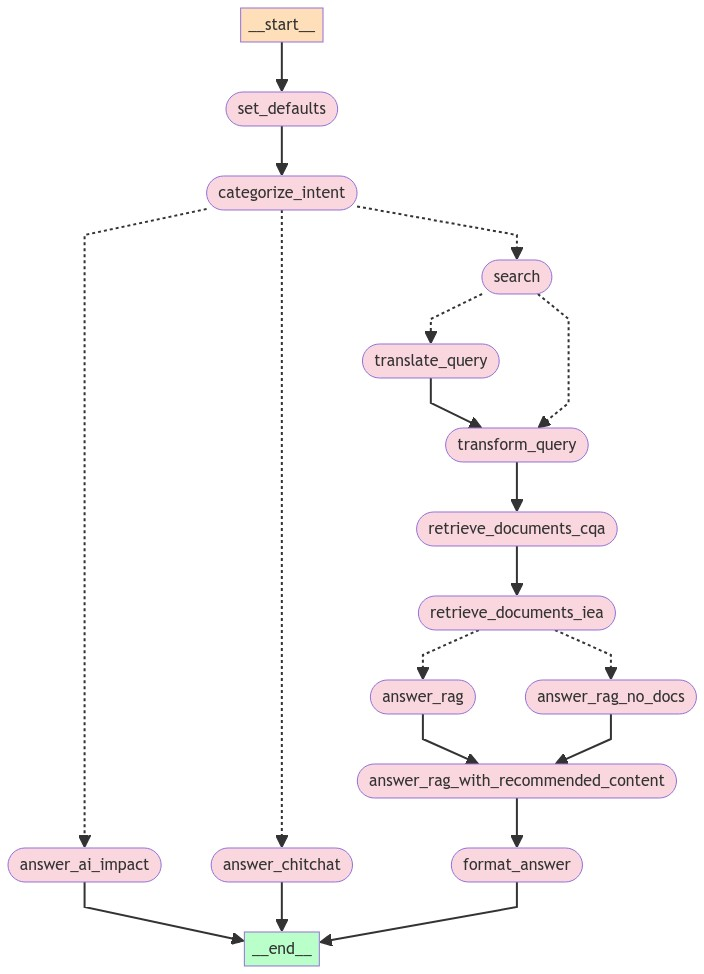

In [10]:
display_graph(agent)

In [12]:
output = await agent.ainvoke({"user_input":"What is hydrogen imports?"})
output

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Batches: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


ValueError: Expected where to have exactly one operator, got {'source': {'$in': ['IPCC']}, 'report_type': {'$in': ['SPM']}}

In [13]:
async for event in agent.astream_events({"user_input":"What is hydrogen imports?"}, version = "v1"):
    print(event)

{'event': 'on_chain_start', 'run_id': '20487d54-a44a-49ed-b1b4-b99bcc3d5179', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': 'What is hydrogen imports?'}}}


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


{'event': 'on_chain_start', 'name': '__start__', 'run_id': '97de4427-a6c4-4ce2-af21-f43ca783fd5e', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'What is hydrogen imports?'}}}
{'event': 'on_chain_end', 'name': '__start__', 'run_id': '97de4427-a6c4-4ce2-af21-f43ca783fd5e', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'What is hydrogen imports?'}, 'output': {'user_input': 'What is hydrogen imports?'}}}
{'event': 'on_chain_start', 'name': 'set_defaults', 'run_id': 'f0923d86-4b2e-4c40-bef9-c4553af46603', 'tags': ['graph:step:1'], 'metadata': {'langgraph_step': 1, 'langgraph_node': 'set_defaults'}, 'data': {}}
{'event': 'on_chain_start', 'name': 'ChannelWrite<set_defaults,user_input,language,intent,query,questions,answer,audience,sources_input,documents,recommended_content,recommended_content_an

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'c4233e75-1046-461f-9894-8ce7fb81d40c', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-c4233e75-1046-461f-9894-8ce7fb81d40c')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'c4233e75-1046-461f-9894-8ce7fb81d40c', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-c4233e75-1046-461f-9894-8ce7fb81d40c')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'c4233e75-1046-461f-9894-8ce7fb81d40c', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_inten

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'adf18ac6-d6d0-4b48-98b6-c47cbb6a1a00', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryDecomposition'}}, id='run-adf18ac6-d6d0-4b48-98b6-c47cbb6a1a00')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'adf18ac6-d6d0-4b48-98b6-c47cbb6a1a00', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-adf18ac6-d6d0-4b48-98b6-c47cbb6a1a00')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'adf18ac6-d6d0-4b48-98b6-c47cbb6a1a00', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', '

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25ed009f-796b-4a07-a8d1-5e5a9d38a8b0', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-25ed009f-796b-4a07-a8d1-5e5a9d38a8b0')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25ed009f-796b-4a07-a8d1-5e5a9d38a8b0', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-25ed009f-796b-4a07-a8d1-5e5a9d38a8b0')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25ed009f-796b-4a07-a8d1-5e5a9d38a8b0', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '70f12c81-4a8b-4236-9c58-485a91c3ddab', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-70f12c81-4a8b-4236-9c58-485a91c3ddab')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '70f12c81-4a8b-4236-9c58-485a91c3ddab', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-70f12c81-4a8b-4236-9c58-485a91c3ddab')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '70f12c81-4a8b-4236-9c58-485a91c3ddab', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '550f61c2-ca79-44df-87f4-1d51f55d0e22', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-550f61c2-ca79-44df-87f4-1d51f55d0e22')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '550f61c2-ca79-44df-87f4-1d51f55d0e22', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-550f61c2-ca79-44df-87f4-1d51f55d0e22')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '550f61c2-ca79-44df-87f4-1d51f55d0e22', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


{'event': 'on_chain_end', 'name': 'retrieve_documents_cqa', 'run_id': '955073fc-56be-416b-858c-2a9ceb1afc69', 'tags': ['graph:step:5'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'retrieve_documents_cqa'}, 'data': {'input': {'user_input': 'What is hydrogen imports?', 'language': 'English', 'intent': 'search', 'query': 'What is hydrogen imports?', 'questions': [{'question': 'What is the role of hydrogen in the energy sector?', 'sources': ['IEA', 'IPCC']}, {'question': 'How are hydrogen imports used in different industries?', 'sources': ['IEA', 'IPCC']}, {'question': "What are the benefits of hydrogen imports for a country's energy supply?", 'sources': ['IEA', 'IPCC']}], 'answer': None, 'audience': 'experts', 'sources_input': ['auto'], 'documents': None, 'recommended_content': None, 'recommended_content_answer': None}, 'output': None}}


ValueError: Expected where to have exactly one operator, got {'source': {'$in': ['IPCC']}, 'report_type': {'$in': ['SPM']}}

: 